<a href="https://colab.research.google.com/github/dubeyabhi07/hands-on-scikit-learn/blob/master/lightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


https://towardsdatascience.com/understanding-lightgbm-parameters-and-how-to-tune-them-6764e20c6e5b

https://neptune.ai/blog/lightgbm-parameters-guide

https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', cache=False)

print(mnist.target)
print(mnist.data.shape)

['5' '0' '4' ... '4' '5' '6']
(70000, 784)


In [ ]:
import pandas as pd
mnist_df = pd.DataFrame(mnist.data, columns=mnist.feature_names)

X = mnist_df[0:5000]
Y = mnist.target[0:5000]
X.head(5)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,147.0,252.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=30, stratify=Y)

In [ ]:
from lightgbm import LGBMClassifier
defaultClf =  LGBMClassifier()
defaultClf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

0.939
0.9380632622048285


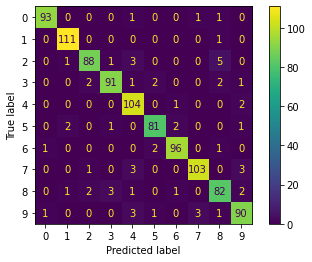

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
x = plot_confusion_matrix(defaultClf, X_test, y_test,values_format = 'd')
print(metrics.accuracy_score(y_test,defaultClf.predict(X_test)))
print(metrics.f1_score(y_test,defaultClf.predict(X_test),average='macro'))

# Difference with XgBoost :

- Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

- LightGBM uses a novel technique of Gradient-based One-Side Sampling (GOSS) to filter out the data instances. GOSS keeps all the instances with large gradients and performs random sampling on the instances with small gradients. For example, let’s say I have 500K rows of data where 10k rows have higher gradients. So my algorithm will choose (10k rows of higher gradient+ x% of remaining 490k rows chosen randomly). Assuming x is 10%, total rows selected are 59k out of 500K on the basis of which split value if found.

- It can explicitely handle categoriacla values, no need to one-hot-encode.

- Faster than any other gradient boosting.

# Parameters :

https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/sklearn.html


- boosting: defines the type of algorithm you want to run, default=gdbt
    - gbdt: traditional Gradient Boosting Decision Tree
    - rf: random forest
    - **dart**: Dropouts meet Multiple Additive Regression Trees
    - goss: Gradient-based One-Side Sampling

- num_boost_round: Number of boosting iterations, typically 100+

- **learning_rate**: This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates. Typical values: 0.1, 0.001, 0.003…

- **num_leaves**: number of leaves in full tree, default: 31

- device: default: cpu, can also pass **gpu**


- max_depth: It describes the maximum depth of tree. This parameter is used to handle model overfitting. Any time you feel that your model is overfitted, my first advice will be to lower max_depth.

- min_data_in_leaf: It is the minimum number of the records a leaf may have. The default value is 20, optimum value. It is also used to deal over fitting

- **feature_fraction**: Used when your boosting is random forest. 0.8 feature fraction means LightGBM will select 80% of parameters randomly in each iteration for building trees.

- **bagging_fraction**(subsample): specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting.

- early_stopping_round: This parameter can help you speed up your analysis. Model will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds. This will reduce excessive iterations


- max_bin: it denotes the maximum number of bin that feature value will bucket in.

- categorical_feature: It denotes the index of categorical features. If categorical_features=0,1,2 then column 0, column 1 and column 2 are categorical variables.


In [ ]:
from lightgbm import LGBMClassifier
params = {
    "learning_rate": [0.03,0.05,0.1,0.15,0.25], 
    "num_leaves": [20,25,28,32,35],
    "n_estimators": [100,200,400,800],
    "subsample": [0.3,0.5,0.75],
    "boosting":['dart','gbdt']
}

from sklearn.model_selection import RandomizedSearchCV
grid_random = RandomizedSearchCV(LGBMClassifier(), params, cv=3, scoring='accuracy', return_train_score=False,n_iter=30 )

grid_random.fit(X_train, y_train)
print(grid_random)

print("---------------------------------------------------------------------------------")
# examine the best model
print(grid_random.best_score_)
print(grid_random.best_params_)
print(grid_random.best_estimator_)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                                            subsample_for_bin=200000,
                                            subsample_f

0.95
0.9493339559763909


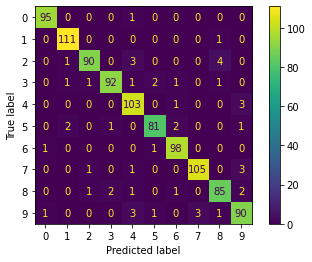

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
_ = plot_confusion_matrix(grid_random.best_estimator_, X_test, y_test,values_format = 'd')
print(metrics.accuracy_score(y_test,grid_random.best_estimator_.predict(X_test)))
print(metrics.f1_score(y_test,grid_random.best_estimator_.predict(X_test),average='macro'))

# Early stopping:

- See if the best estimator form cross validation can still be improved.

In [ ]:
model_earlyStop = LGBMClassifier(subsample= 0.5, num_leaves= 20, n_estimators= 2000, learning_rate=0.05, random_state=42, eval_metric='merror')
model_earlyStop.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_test, y_test)])

y_pred = model_earlyStop.predict(X_test)

In [ ]:
print(metrics.accuracy_score(y_test,model_earlyStop.predict(X_test)))
print(metrics.f1_score(y_test,model_earlyStop.predict(X_test),average='macro'))

0.945
0.9438474726197938


# Takeaways:

- Following set of practices can be used to improve your model efficiency.
  - **num_leaves:** This is the main parameter to control the complexity of the tree model. Ideally, the value of num_leaves should be less than or equal to 2^(max_depth). Value more than this will result in overfitting.
  - **min_data_in_leaf**: Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
  - **max_depth**: You also can use max_depth to limit the tree depth explicitly.

- For Faster Speed:

  - Use bagging by setting bagging_fraction and bagging_freq
  - Use feature sub-sampling by setting feature_fraction
  - Use small max_bin
  - Use save_binary to speed up data loading in future learning
  - Use parallel learning, refer to parallel learning guide.

- For better accuracy:
  - Use large max_bin (may be slower)
  - Use small learning_rate with large num_iterations
  - Use large num_leaves(may cause over-fitting)
  - Use bigger training data
  - Try dart
  - Try to use categorical feature directly

- To deal with over-fitting:
  - Use small max_bin
  - Use small num_leaves
  - Use min_data_in_leaf and min_sum_hessian_in_leaf
  - Use bagging by set bagging_fraction and bagging_freq
  - Use feature sub-sampling by set feature_fraction
  - Use bigger training data
  - Try lambda_l1, lambda_l2 and min_gain_to_split to regularization
  - Try max_depth to avoid growing deep tree


# Using hyperopt for parameter searching :

In [ ]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

def hyperopt_train_test(params):
    clf = LGBMClassifier(**params )
    score = cross_val_score(clf, X_train, y_train,cv=4,scoring='accuracy').mean()
    print("score {:.4f} params {}".format(score, params))
    return -score

space4rf = {
    'num_leaves': hp.choice('max_depth', range(20,40)),
    'subsample': hp.uniform('subsample', 0.2,0.8),
    'n_estimators': hp.choice('n_estimators',range(100,500)),
    'boosting': hp.choice('boosting',['gbdt','dart'])

}

best = fmin(hyperopt_train_test, space4rf, algo=tpe.suggest, max_evals=30)

score 0.9365 params {'boosting': 'gbdt', 'n_estimators': 433, 'num_leaves': 34, 'subsample': 0.72278800696046}
score 0.9373 params {'boosting': 'gbdt', 'n_estimators': 179, 'num_leaves': 25, 'subsample': 0.4816008709137918}
score 0.9370 params {'boosting': 'gbdt', 'n_estimators': 375, 'num_leaves': 24, 'subsample': 0.32903432506326524}
score 0.9330 params {'boosting': 'dart', 'n_estimators': 440, 'num_leaves': 31, 'subsample': 0.7192109548241699}
score 0.9310 params {'boosting': 'dart', 'n_estimators': 354, 'num_leaves': 20, 'subsample': 0.3036712326373524}
score 0.9327 params {'boosting': 'gbdt', 'n_estimators': 144, 'num_leaves': 27, 'subsample': 0.7411524741236293}
score 0.9373 params {'boosting': 'gbdt', 'n_estimators': 460, 'num_leaves': 27, 'subsample': 0.3702024388239949}
score 0.9325 params {'boosting': 'dart', 'n_estimators': 493, 'num_leaves': 24, 'subsample': 0.7628726807632504}
score 0.9370 params {'boosting': 'gbdt', 'n_estimators': 294, 'num_leaves': 21, 'subsample': 0.51

In [ ]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'boosting': 0, 'max_depth': 10, 'n_estimators': 232, 'subsample': 0.6704055012770141}


In [ ]:
best['boosting'] = 'gbdt'
best_estimator = LGBMClassifier(**best )
best_estimator.fit(X_train,y_train)

LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=10, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=232, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=0.6704055012770141,
               subsample_for_bin=200000, subsample_freq=0)

just checking .......................
1.0
actual predictions ...................
0.946
0.9449583725403421


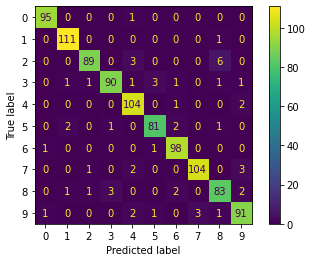

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
_ = plot_confusion_matrix(best_estimator, X_test, y_test,values_format = 'd')
print("just checking .......................")
print(metrics.accuracy_score(y_train,best_estimator.predict(X_train)))
print("actual predictions ...................")
print(metrics.accuracy_score(y_test,best_estimator.predict(X_test)))
print(metrics.f1_score(y_test,best_estimator.predict(X_test),average='macro'))

# Handling catagotical values :

- One-Hot-Encoding : It learns by treating each of the binary levels independently. If there is a categorical feature with 4 different options, one, atomic split of the tree will be performed based on only one piece of information. Therefore the strength of each split is harmed. Each level is counted separately.

- Categorical LGBM encoding : The split can be made based on the variable being of one specific level or any subset of levels. You have 2^N (bits like) splits available instead of 4 for one-hot-encoding. Each split is counted.

So, though Categorical LGBM encoding is the strongest, but definitely the easiest to over-fit. And when we combine it with the well known tendency of trees to be biased towards categorical variables, we can get weird results.

In [ ]:
import pandas as pd
df = pd.read_csv('pokemon.csv', delimiter = ',')

In [ ]:
df.head(5)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [ ]:
y = df['Legendary']
x = df.drop(['#', 'Name','Legendary'], axis = 1) 

In [ ]:
x.dtypes

Type 1        object
Type 2        object
Total          int64
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
dtype: object

In [ ]:
# Transform categorical features into the appropriate type that is expected by LightGBM
for c in x.columns:
  col_type = x[c].dtype
  if col_type == 'object' or col_type.name == 'category':
    x[c] = x[c].astype('category')
x.dtypes

Type 1        category
Type 2        category
Total            int64
HP               int64
Attack           int64
Defense          int64
Sp. Atk          int64
Sp. Def          int64
Speed            int64
Generation       int64
dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101, stratify=y)

In [ ]:
from lightgbm import LGBMClassifier
model_with_cat = LGBMClassifier()
model_with_cat.fit(X_train, y_train, feature_name='auto', categorical_feature = 'auto')

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

0.9375
0.7747747747747749


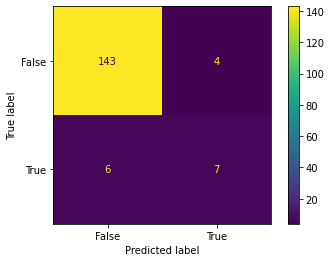

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
_ = plot_confusion_matrix(model_with_cat, X_test, y_test,values_format = 'd')
print(metrics.accuracy_score(y_test,model_with_cat.predict(X_test)))
print(metrics.f1_score(y_test,model_with_cat.predict(X_test),average='macro'))

In [ ]:
x1 = pd.concat([pd.get_dummies(x[['Type 1', 'Type 2']]),x.drop(['Type 1', 'Type 2'], axis = 1)], axis =1) 

In [ ]:
x1.head(5)

,Type 1_Bug,Type 1_Dark,Type 1_Dragon,Type 1_Electric,Type 1_Fairy,Type 1_Fighting,Type 1_Fire,Type 1_Flying,Type 1_Ghost,Type 1_Grass,Type 1_Ground,Type 1_Ice,Type 1_Normal,Type 1_Poison,Type 1_Psychic,Type 1_Rock,Type 1_Steel,Type 1_Water,Type 2_Bug,Type 2_Dark,Type 2_Dragon,Type 2_Electric,Type 2_Fairy,Type 2_Fighting,Type 2_Fire,Type 2_Flying,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,318,45,49,49,65,65,45,1
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,405,60,62,63,80,80,60,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,525,80,82,83,100,100,80,1
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,625,80,100,123,122,120,80,1
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,309,39,52,43,60,50,65,1


In [ ]:
X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y, test_size=0.2, random_state=101, stratify=y)
model_without_cat = LGBMClassifier()
model_without_cat.fit(X1_train, y1_train, feature_name='auto')

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

0.9375
0.7906855049712193


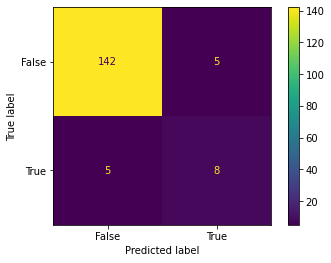

In [ ]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
_ = plot_confusion_matrix(model_without_cat, X1_test, y1_test,values_format = 'd')
print(metrics.accuracy_score(y1_test,model_without_cat.predict(X1_test)))
print(metrics.f1_score(y1_test,model_without_cat.predict(X1_test),average='macro'))